In [10]:
# Modifed code to work with our dataset
# Added data import and handling of our data
# Added data regularization
# updated for multiple inputs
# updated to split data evenly between different sources
# Transformed data using log10(Rex) and log10(Nux) before training- massively improved accuracy (from 26% to ~9% error)
# Updated so model prints metrics for each separate fluid as well
# Added ability to pick different loss function
# Added ability to pick different activation function

### Import modules and data

In [11]:
# Import Modules
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import copy 

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set seeds for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

Using device: cpu


In [12]:
# Import data
df = pd.read_excel("https://raw.githubusercontent.com/adhicurry/ML_HeatTransfer_Fluids/main/FlatPlate_Models/Data_Combined_1.xlsx", engine='openpyxl')
# Replace Wall BC to numerical value
pd.set_option('future.no_silent_downcasting', True)
df['WallBC'] = df['WallBC'].replace({'UWT': 0, 'UHF': 1}).astype(float)

# Common commands
#df.describe()
df.columns
#df[['Rex', 'Nux', 'Pr']]    # Access multiple columns
#df['Figure'].unique()         # List unique ones


Index(['Figure', 'WallBC', 'Pr', 'c', 'Rex', 'Nux', 'Dataset_Label',
       'data_name_lienhard', 'Dataset author and year', 'Fluid'],
      dtype='object')

In [13]:
# Actual data used for ANN development

# data_subset = df[df['Figure'].isin([2])]   # One figure only
# data_subset = df[df['Figure'].isin([2, 3, '4a', '4b', '4c'])]  ## Air only
data_subset = df[df['Figure'].isin([2, 3, '4a', '4b', '4c', '6a','6b', 8 , '9a'])]  ## Air Water and Oil (except Fig 9b)

data_subset = data_subset.reset_index(drop=True)

data_subset.info()
#data_subset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Figure                   526 non-null    object 
 1   WallBC                   526 non-null    float64
 2   Pr                       526 non-null    float64
 3   c                        526 non-null    float64
 4   Rex                      526 non-null    float64
 5   Nux                      526 non-null    float64
 6   Dataset_Label            526 non-null    object 
 7   data_name_lienhard       526 non-null    object 
 8   Dataset author and year  526 non-null    object 
 9   Fluid                    526 non-null    object 
dtypes: float64(5), object(5)
memory usage: 41.2+ KB


## ANN Code

### Data split

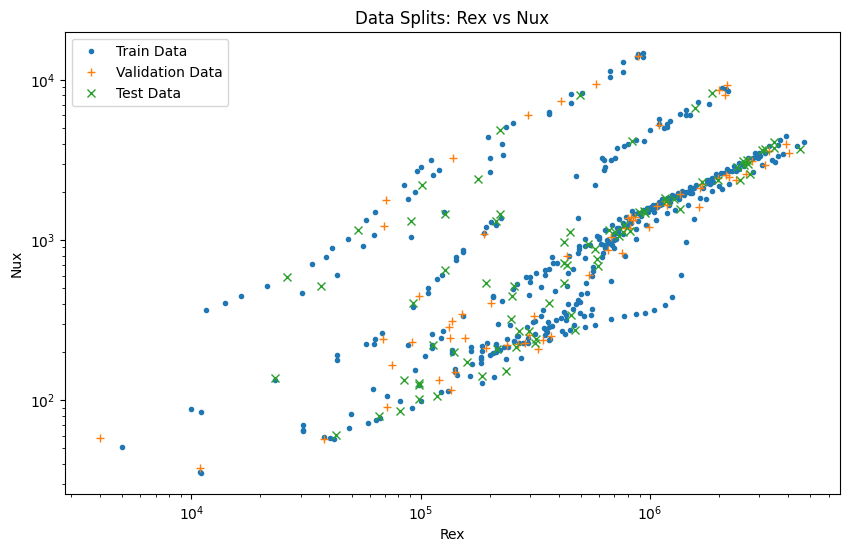

In [14]:
# Define input features and output label
X = data_subset[['Rex', 'Pr', 'WallBC']].values
y = data_subset['Nux'].values
figures = data_subset['Figure'].astype(str).values

# Add log transformation
X[:, 0] = np.log10(X[:, 0])  # Transform Rex (first column)
y = np.log10(y)              # Transform Nux

# Split Data into training, validation, and testing
# First split: separate test data from entire data (% of data)
X_train_temp, X_test, y_train_temp, y_test, fig_train_temp, fig_test = train_test_split(
    X, y, figures,
    test_size=0.15, # CAN MODIFY THIS
    stratify=figures,
    shuffle=True,
    random_state=random_seed
)

# Second split: separate validation data from training data
X_train, X_val, y_train, y_val, fig_train, fig_val = train_test_split(
    X_train_temp, y_train_temp, fig_train_temp,
    test_size=0.15, # CAN MODIFY THIS
    stratify=fig_train_temp,
    shuffle=True,
    random_state=random_seed
)

# Initialize scalers
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
y_scaler = StandardScaler()

# Fit scalers on training data and transform all sets
X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)

# Reshape y values to 2D array for scaling
y_train_2d = y_train.reshape(-1, 1)
y_val_2d = y_val.reshape(-1, 1)
y_test_2d = y_test.reshape(-1, 1)
y_train_scaled = y_scaler.fit_transform(y_train_2d)
y_val_scaled = y_scaler.transform(y_val_2d)
y_test_scaled = y_scaler.transform(y_test_2d)

# Convert to PyTorch Tensors and move to device
X_train = torch.Tensor(X_train_scaled).float().to(device)
y_train = torch.Tensor(y_train_scaled).float().to(device)
X_val = torch.Tensor(X_val_scaled).float().to(device)
y_val = torch.Tensor(y_val_scaled).float().to(device)
X_test = torch.Tensor(X_test_scaled).float().to(device)
y_test = torch.Tensor(y_test_scaled).float().to(device)

# Save scalers for later use (important for making predictions on new data)
import joblib
joblib.dump(X_scaler, 'X_scaler.save')
joblib.dump(y_scaler, 'y_scaler.save')

# Visualize all data splits
plt.figure(figsize=(10, 6))
# Need to apply 10** to inverse the log transformation after inverse_transform
plt.loglog(10**X_scaler.inverse_transform(X_train.cpu().numpy())[:, 0], 
           10**y_scaler.inverse_transform(y_train.cpu().numpy()), '.', label='Train Data')
plt.loglog(10**X_scaler.inverse_transform(X_val.cpu().numpy())[:, 0], 
           10**y_scaler.inverse_transform(y_val.cpu().numpy()), '+', label='Validation Data')
plt.loglog(10**X_scaler.inverse_transform(X_test.cpu().numpy())[:, 0], 
           10**y_scaler.inverse_transform(y_test.cpu().numpy()), 'x', label='Test Data')
plt.xlabel('Rex')
plt.ylabel('Nux')
plt.title('Data Splits: Rex vs Nux')
plt.legend()
plt.show()

### Define Neural Network

In [15]:
# Define Neural Network
# Define Neural Network Architecture and Training Parameters 
# (Note to change the # of layers must be done manually in the class def below)
config = {
    'input_size': 4,         # Number of features in each input sample
    'hidden_size': 128,      # Number of neurons in the hidden layer, controls model capacity
    'output_size': 1,        # Number of output values predicted by the model
    'learning_rate': 0.001,  # Step size for gradient descent optimization
    'batch_size': 256,        # Number of samples processed in each training iteration
    'num_epochs': 2500,      # Number of complete passes through the training dataset
    'weight_decay': 0.001,  # L2 regularization strength to prevent overfitting
    'dropout_rate': 0.05     # Fraction of neurons randomly deactivated during training
}

def predict(model, X):
    """Make predictions using the trained model."""
    model.eval()
    with torch.no_grad():
        # Convert input to tensor if it's not already
        if not isinstance(X, torch.Tensor):
            X = torch.Tensor(X).float().to(device)  # Removed .view(-1, 1) since we have multiple features
        predictions = model(X)
        return predictions.cpu().numpy().ravel()

# Define Neural Network Architecture
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.1):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
        self.activationFN = nn.ReLU()                  # PICK ACTIVATION FUNCTION nn.ReLU(), nn.LeakyRelU(), nn.Tanh(), nn.Sigmoid(), nn.SiLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)  
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
    
    def forward(self, X):
        X = self.layer1(X)
        X = self.batch_norm1(X)
        X = self.activationFN(X)
        X = self.dropout(X)
        
        X = self.layer2(X)
        X = self.batch_norm2(X)
        X = self.activationFN(X)
        X = self.dropout(X)
        
        X = self.layer3(X)
        return X
    
    def save(self, path):
        """Save model parameters."""
        torch.save(self.state_dict(), path)
    
    def load(self, path):
        """Load model parameters."""
        self.load_state_dict(torch.load(path))

# Initialize model using config
model = NN(
    config['input_size'], 
    config['hidden_size'], 
    config['output_size'],
    config['dropout_rate']
).to(device)

# Pick Loss function
criterion = nn.L1Loss()                # Mean Absolute Error (MAE)
#criterion = nn.MSELoss()               # Mean Squared Error Loss (MSE)
#criterion = nn.SmoothL1Loss(beta=0.5)   # Huber loss

#Pick Optimizer
optimizer = optim.Adam(model.parameters(), 
                      lr=config['learning_rate'],
                      weight_decay=config['weight_decay'])  # Added weight_decay for L2 regularization

# Create data loaders for both training and validation
train_dataset = TensorDataset(X_train, y_train)  
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))

### Run ML Model

Epoch [10/2500], Train Loss: 0.285539, Val Loss: 0.463453
Epoch [20/2500], Train Loss: 0.248836, Val Loss: 0.207786
Epoch [30/2500], Train Loss: 0.244102, Val Loss: 0.196155
Epoch [40/2500], Train Loss: 0.235055, Val Loss: 0.191278
Epoch [50/2500], Train Loss: 0.223232, Val Loss: 0.189986
Epoch [60/2500], Train Loss: 0.213437, Val Loss: 0.194217
Epoch [70/2500], Train Loss: 0.240659, Val Loss: 0.192003
Epoch [80/2500], Train Loss: 0.238673, Val Loss: 0.182339
Epoch [90/2500], Train Loss: 0.234288, Val Loss: 0.199594
Epoch [100/2500], Train Loss: 0.210118, Val Loss: 0.182912
Epoch [110/2500], Train Loss: 0.220841, Val Loss: 0.196529
Epoch [120/2500], Train Loss: 0.186282, Val Loss: 0.179422
Epoch [130/2500], Train Loss: 0.204044, Val Loss: 0.177784
Epoch [140/2500], Train Loss: 0.193487, Val Loss: 0.191224
Epoch [150/2500], Train Loss: 0.218006, Val Loss: 0.168977
Epoch [160/2500], Train Loss: 0.187861, Val Loss: 0.175158
Epoch [170/2500], Train Loss: 0.185519, Val Loss: 0.164871
Epoch 

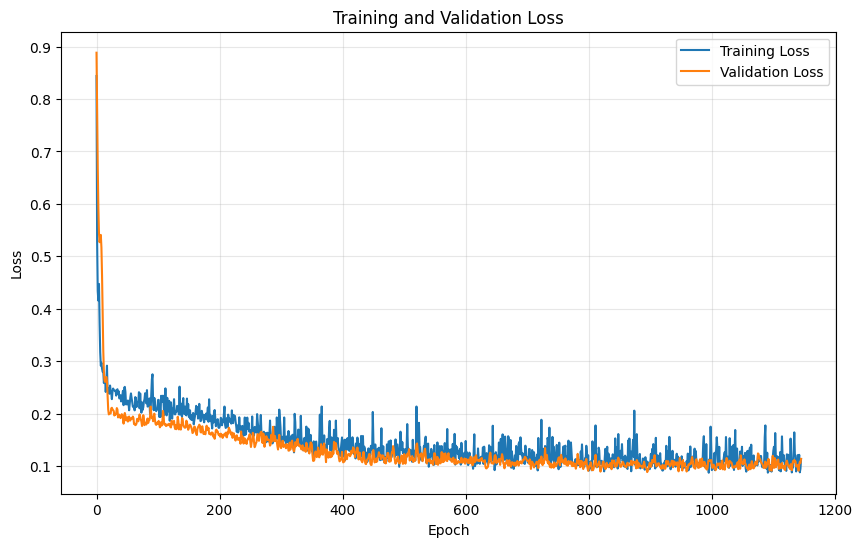

In [16]:
train_losses = []
val_losses = []

# Add variables for tracking best model and early stopping
best_val_loss = float('inf')
best_model = None
patience = 250  # Number of epochs to wait before early stopping
patience_counter = 0

for epoch in range(config['num_epochs']):
    # Training phase
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_batches = 0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            val_batches += 1
        val_loss = val_loss / val_batches  # Average validation loss
        val_losses.append(val_loss)
        
        # Save the model if it has the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            patience_counter = 0  # Reset counter
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{config["num_epochs"]}], '
              f'Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

print(f'Best validation loss: {best_val_loss:.6f}')

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
#plt.yscale('log')  # Optional: use log scale for better visualization
plt.show()

Category                 Overall    air     oil   water
Metric                                                 
Average_Percentage_Error    7.76   7.83    7.13    7.88
MAE                        85.87  72.91  135.71  111.14
Max_Error                  37.35  30.19   25.23   37.35
Median_Error                6.00   6.18    4.26    2.07
Min_Error                   0.23   0.23    0.65    0.89
Percentile_68               7.96   8.37    7.21    4.26
Percentile_95              25.34  23.21   19.35   33.54
Percentile_99              31.94  27.96   24.06   36.59


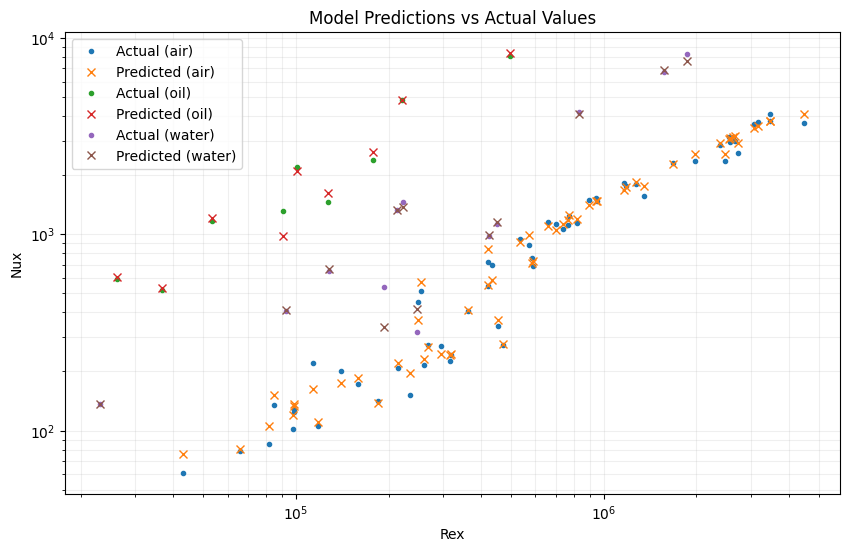

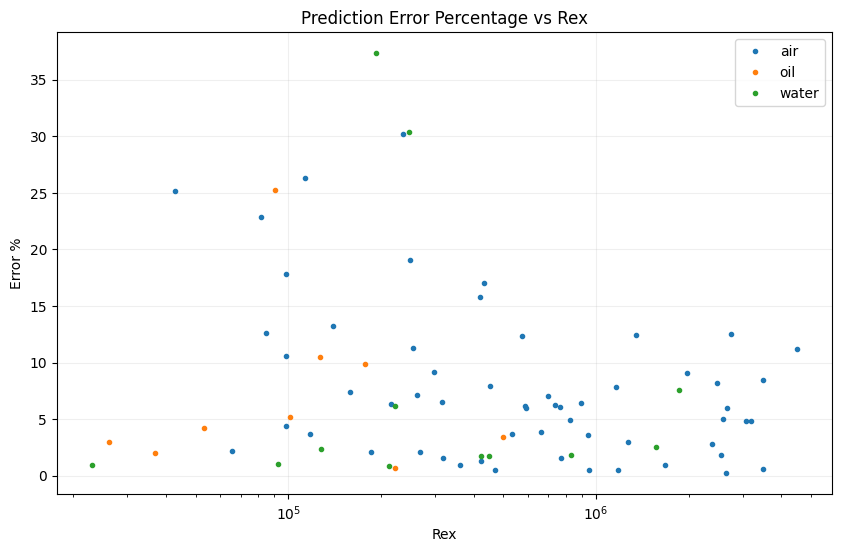

In [17]:
# Save and load model remains the same
best_model.save('best_NN_Model.pth')
model = best_model

# Evaluation function to calculate metrics
def calculate_metrics(predictions, actual_values):
    error_percentages = 100 * np.abs(predictions - actual_values) / actual_values
    metrics = {
        'MAE': np.mean(np.abs(predictions - actual_values)),
        'Average_Percentage_Error': np.mean(error_percentages),
        'Min_Error': np.min(error_percentages),
        'Max_Error': np.max(error_percentages),
        'Median_Error': np.median(error_percentages),
        'Percentile_68': np.percentile(error_percentages, 68),
        'Percentile_95': np.percentile(error_percentages, 95),
        'Percentile_99': np.percentile(error_percentages, 99),
        'Num_Samples': len(predictions)
    }
    return metrics

# Evaluation section
with torch.no_grad():
    model.eval()
    predictions = model(X_test)
    
    # First inverse transform the scaled predictions and actual values
    predictions_scaled = predictions.cpu().numpy()
    y_test_scaled = y_test.cpu().numpy()
    
    predictions_log = y_scaler.inverse_transform(predictions_scaled)
    y_test_log = y_scaler.inverse_transform(y_test_scaled)
    
    # Then inverse the log transformation
    predictions_original = 10**predictions_log
    y_test_original = 10**y_test_log
    
    # Get original Rex values
    X_test_scaled = X_test.cpu().numpy()
    X_test_log = X_scaler.inverse_transform(X_test_scaled)
    actual_Rex = 10**X_test_log[:, 0]
    
    # Get fluid types using the actual Rex values to match back to original data
    test_fluids = []
    for rex in actual_Rex:
        # Find the closest Rex in the original dataset
        idx = np.abs(data_subset['Rex'].values - rex).argmin()
        test_fluids.append(data_subset['Fluid'].iloc[idx])
    fluid_types = np.array(test_fluids)
    
    # Calculate overall metrics
    overall_metrics = calculate_metrics(predictions_original, y_test_original)
    
    # Calculate metrics by fluid type
    fluid_results = {}
    for fluid in np.unique(fluid_types):
        mask = fluid_types == fluid
        fluid_results[fluid] = calculate_metrics(
            predictions_original[mask], 
            y_test_original[mask]
        )
 
    # Create the DataFrame
    overall_data = [
        ["Overall", metric_name, value]
        for metric_name, value in overall_metrics.items()
        if metric_name != "Num_Samples"
    ]
    fluid_data = [
        [fluid, metric_name, value]
        for fluid, metrics in fluid_results.items()
        for metric_name, value in metrics.items()
        if metric_name != "Num_Samples"
    ]
    combined_data = overall_data + fluid_data
    df = pd.DataFrame(combined_data, columns=["Category", "Metric", "Value"])
    
    # Format the output
    df["Value"] = df["Value"].apply(lambda x: f"{x:.2f}")  # Format values to 2 decimal places
    styled_df = df.pivot(index="Metric", columns="Category", values="Value")  # Pivot for cleaner display
    print(styled_df.fillna("").to_string())  # Replace NaN with empty strings for clarity


    # Plotting section - separate by fluid
    plt.figure(figsize=(10, 6))
    for fluid in np.unique(fluid_types):
        mask = fluid_types == fluid
        plt.loglog(actual_Rex[mask], y_test_original[mask], '.', label=f'Actual ({fluid})')
        plt.loglog(actual_Rex[mask], predictions_original[mask], 'x', label=f'Predicted ({fluid})')
    
    plt.title('Model Predictions vs Actual Values')
    plt.xlabel('Rex')
    plt.ylabel('Nux')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    plt.show()

    # Error percentage plot - separate by fluid
    plt.figure(figsize=(10, 6))
    for fluid in np.unique(fluid_types):
        mask = fluid_types == fluid
        error_percentage = 100 * np.abs(predictions_original[mask] - y_test_original[mask]) / y_test_original[mask]
        plt.semilogx(actual_Rex[mask], error_percentage, '.', label=fluid)
    
    plt.title('Prediction Error Percentage vs Rex')
    plt.xlabel('Rex')
    plt.ylabel('Error %')
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.show()

### Using ML Model with the best weights to recreate figures in lienhard paper

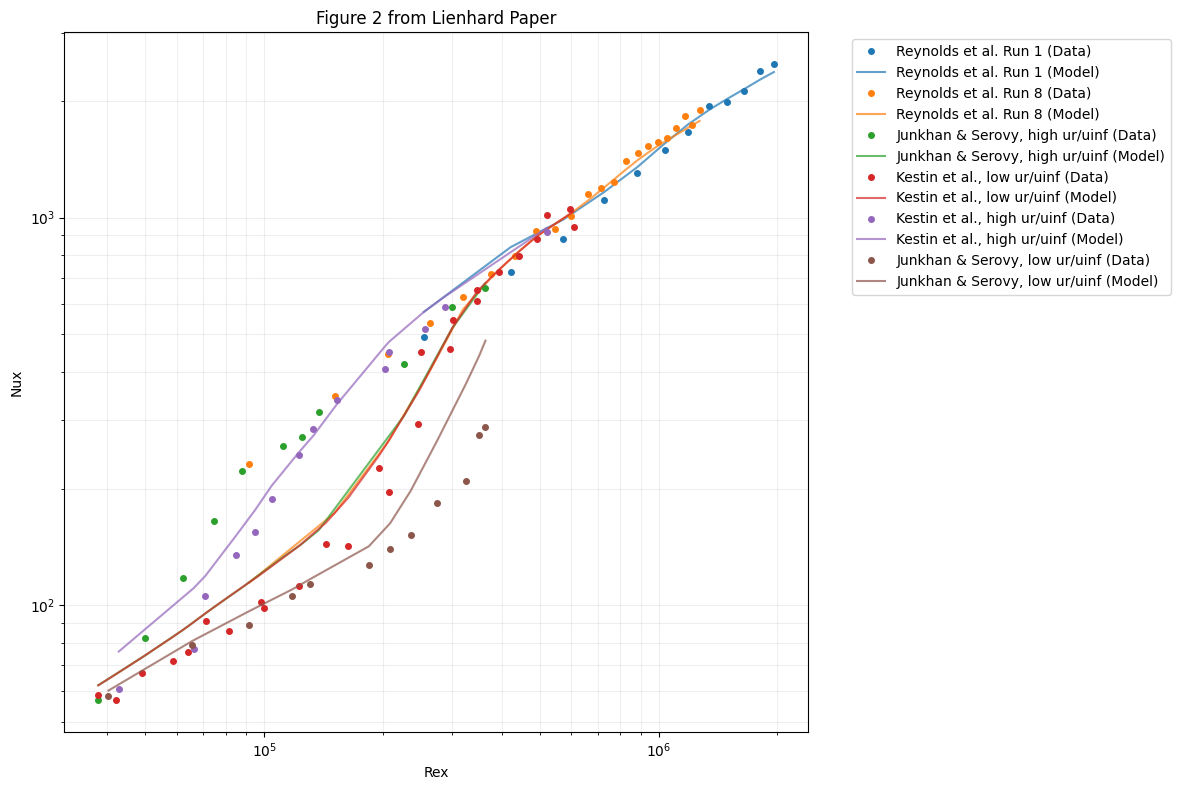

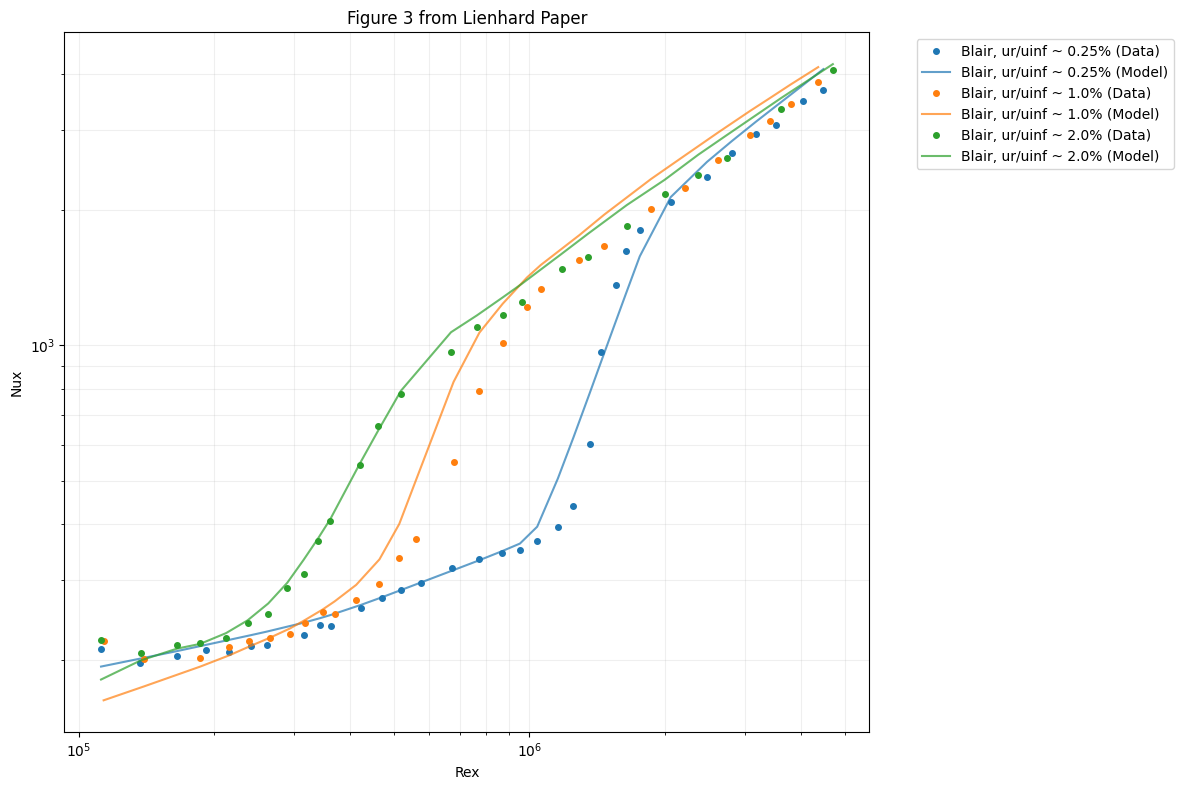

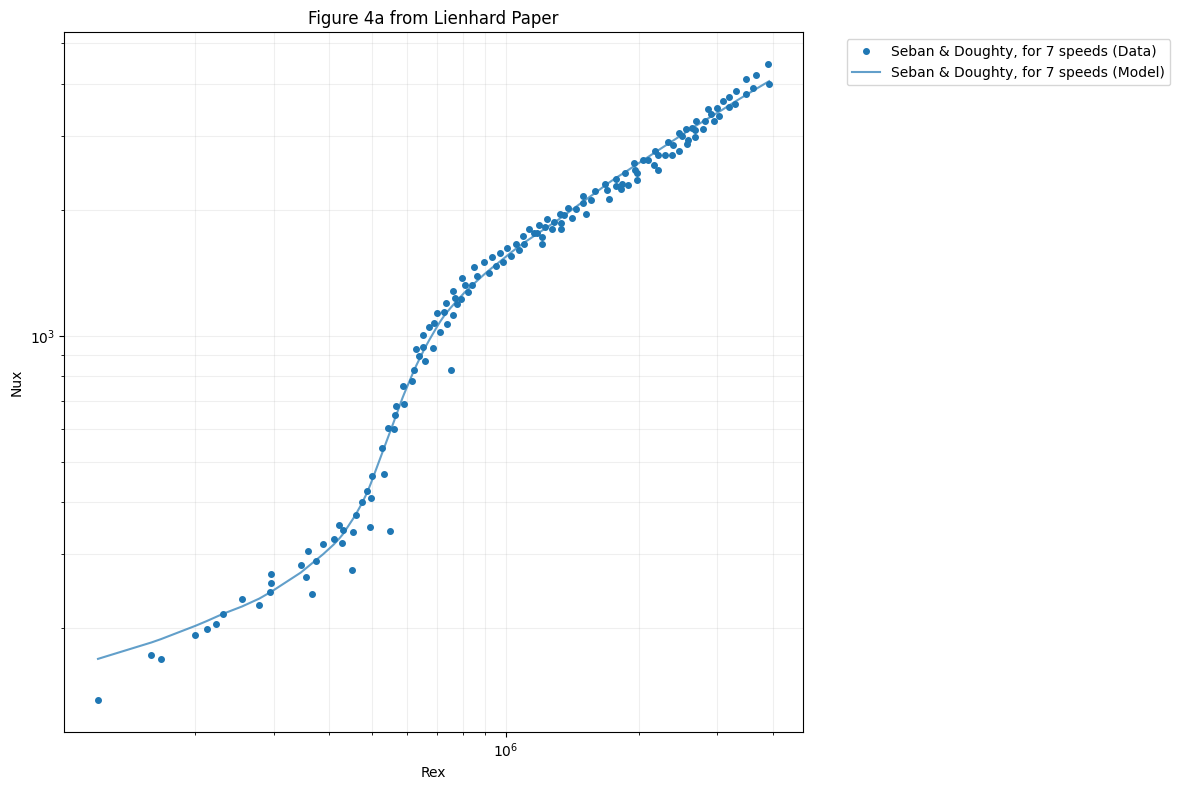

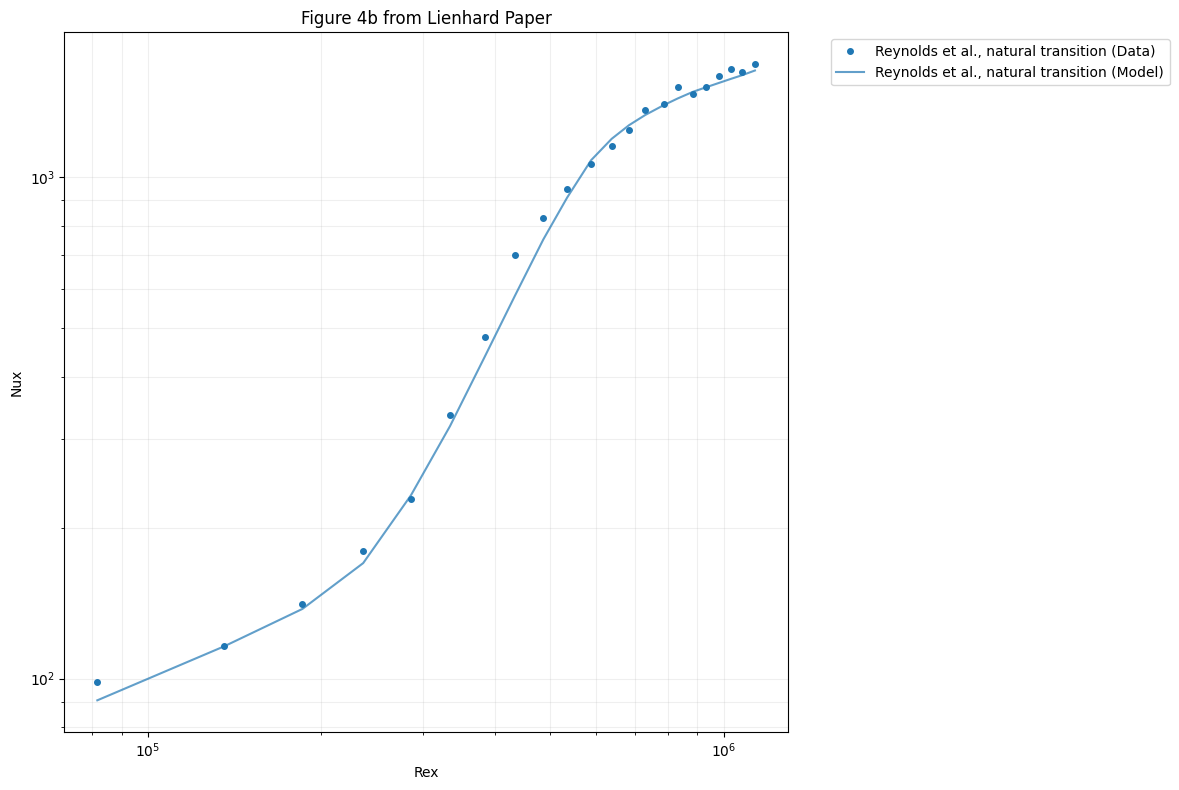

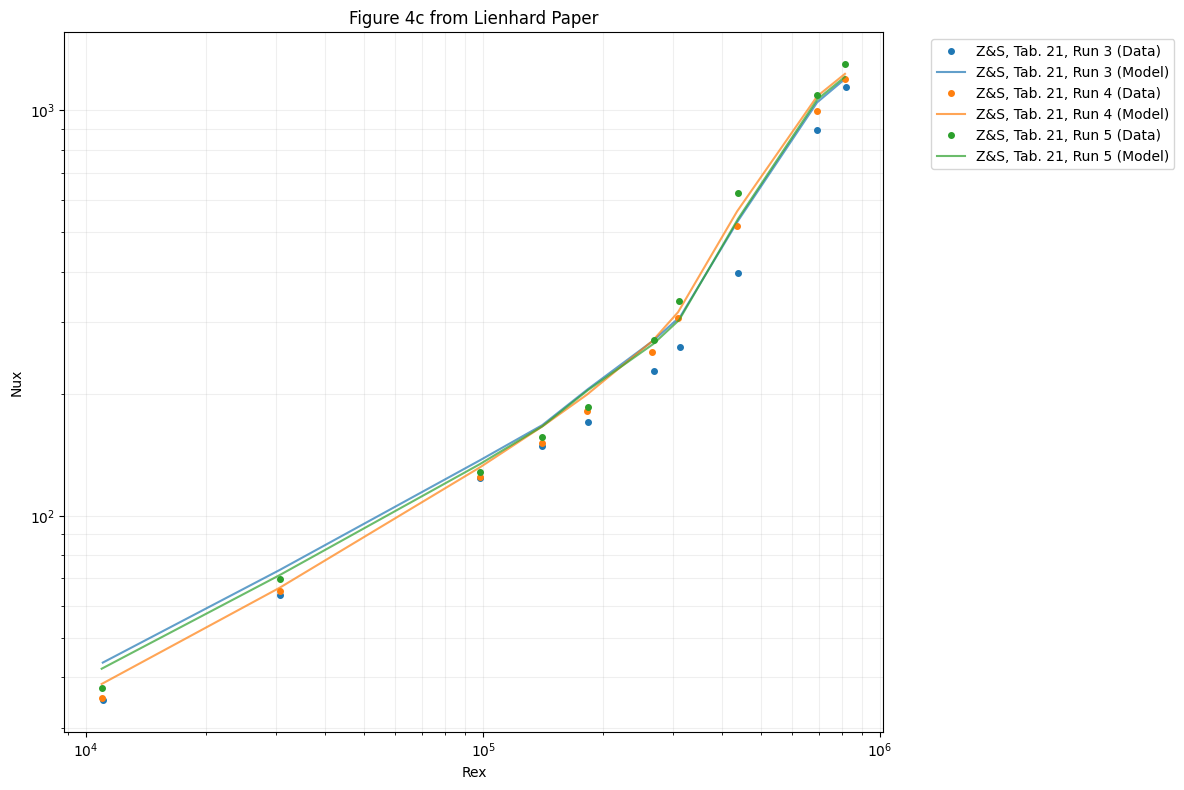

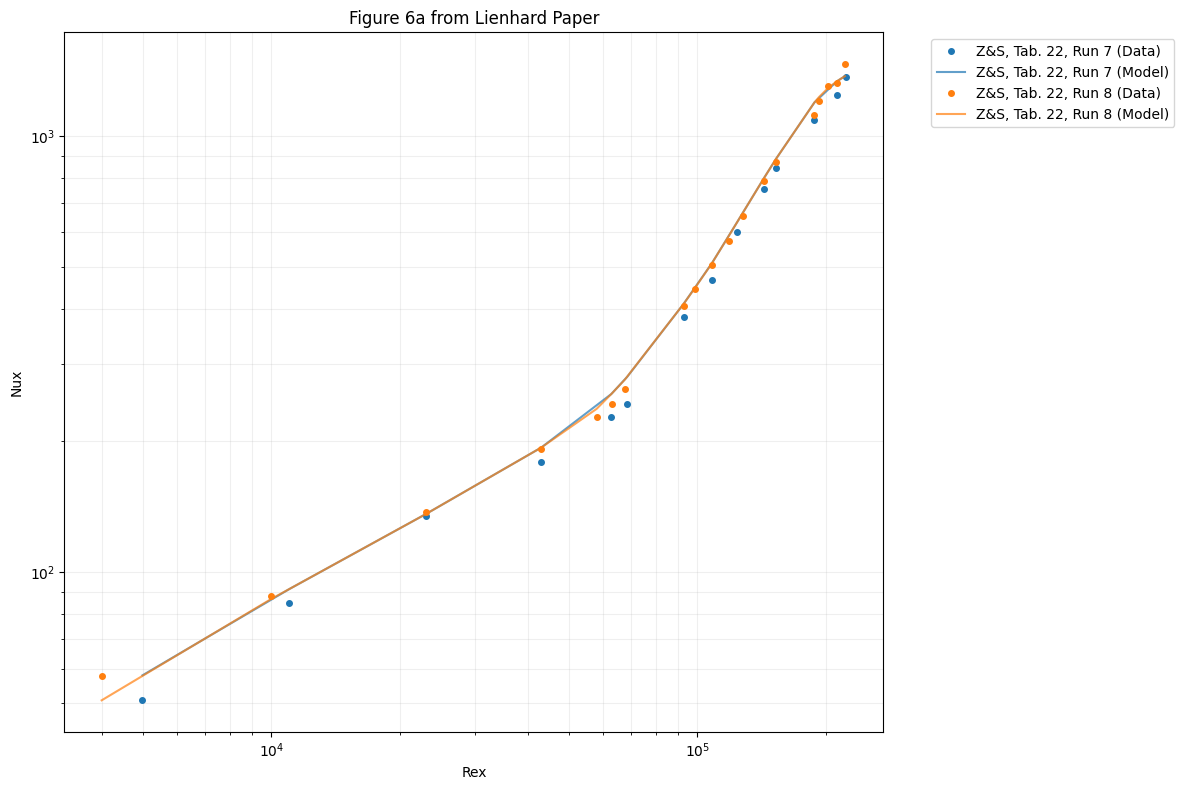

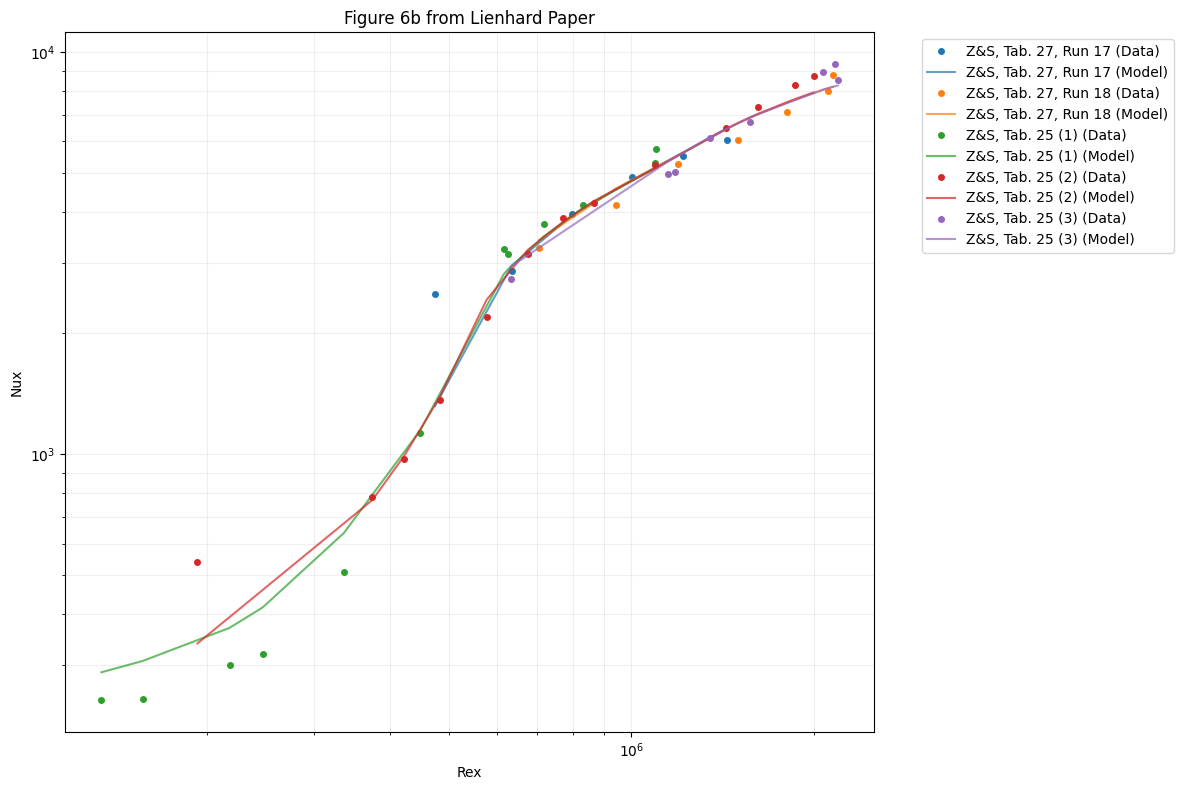

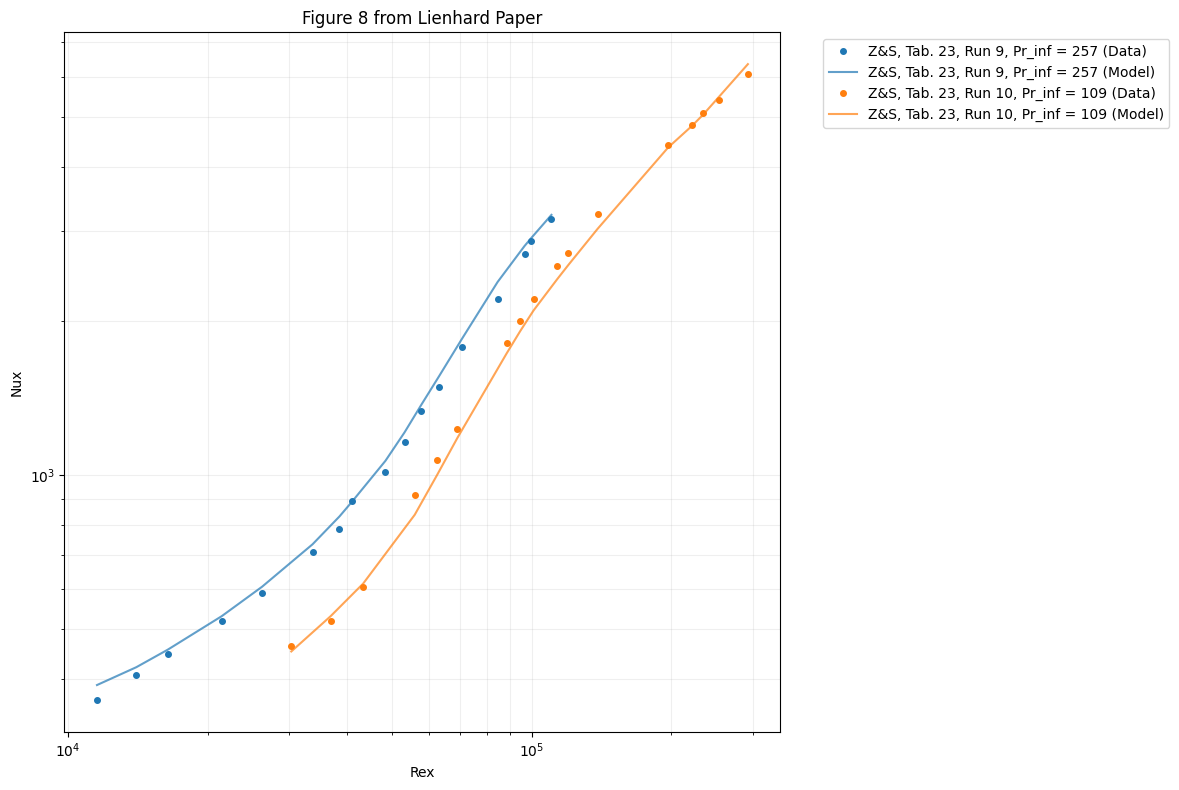

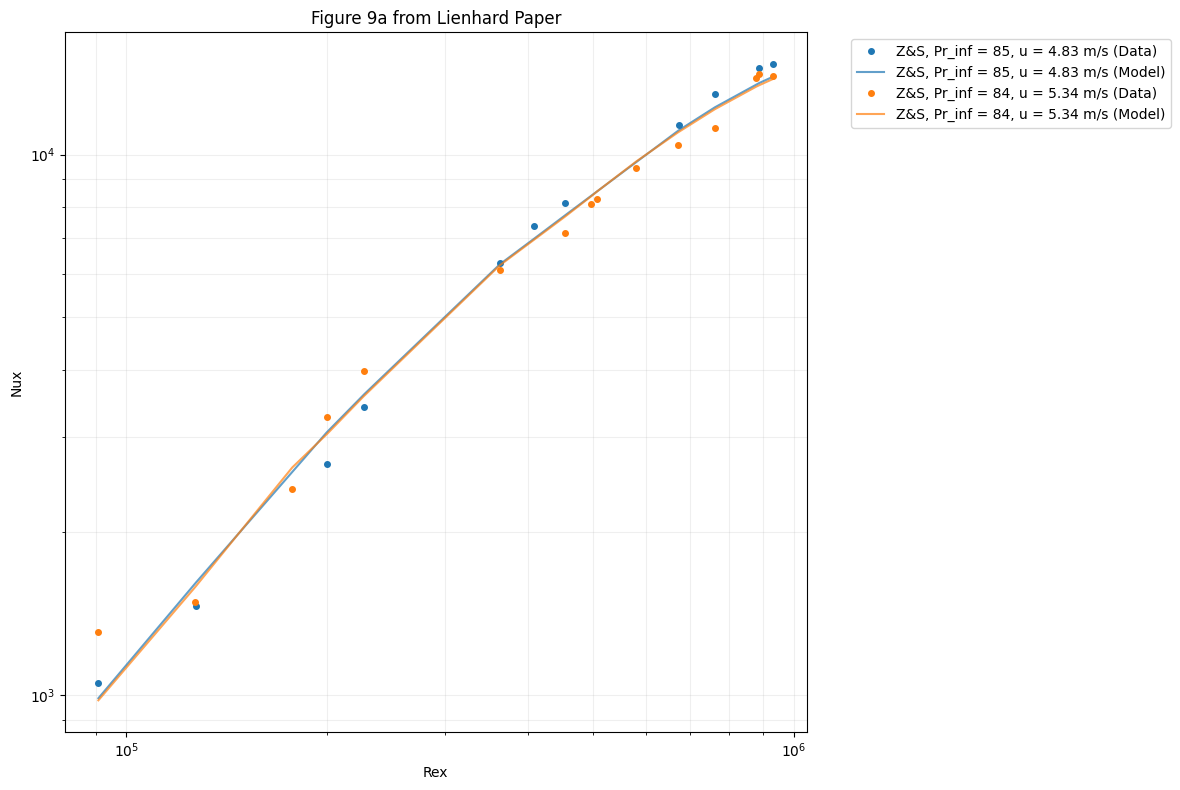

In [18]:
# First load the model with saved weights
loaded_model = NN(
    config['input_size'], 
    config['hidden_size'], 
    config['output_size'],
    config['dropout_rate']
).to(device)
# Modified loading to use weights_only=True
loaded_model.load_state_dict(torch.load('best_NN_Model.pth', weights_only=True))
# Rest of the code remains exactly the same
# Create test data for each figure
figures_to_plot = data_subset['Figure'].unique()
for fig in figures_to_plot:
    # Get data for this figure
    fig_data = data_subset[data_subset['Figure'] == fig]
    
    # Prepare input features
    X_fig = fig_data[['Rex', 'Pr', 'WallBC', 'c']].values
    
    # Apply log transformation to Rex
    X_fig[:, 0] = np.log10(X_fig[:, 0])
    
    # Scale the input
    X_fig_scaled = X_scaler.transform(X_fig)
    
    # Convert to tensor
    X_fig_tensor = torch.Tensor(X_fig_scaled).float().to(device)
    
    # Make predictions
    with torch.no_grad():
        loaded_model.eval()
        predictions = loaded_model(X_fig_tensor)
        
        # Transform predictions back to original scale
        predictions_scaled = predictions.cpu().numpy()
        predictions_log = y_scaler.inverse_transform(predictions_scaled)
        predictions_original = 10**predictions_log
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    # Create a color map to ensure consistent colors
    color_map = plt.colormaps['tab10']

    # Get unique datasets for this figure
    datasets = fig_data['data_name_lienhard'].unique()
    
    for i, dataset in enumerate(datasets):
        # Get data for this dataset
        mask = fig_data['data_name_lienhard'] == dataset
        
        # Choose a consistent color for this dataset
        dataset_color = color_map(i % color_map.N)
        
        # Plot original data
        plt.loglog(fig_data[mask]['Rex'], 
                  fig_data[mask]['Nux'], 
                  'o', 
                  color=dataset_color, 
                  label=f'{dataset} (Data)', 
                  markersize=4)
        
        # Plot model predictions
        sort_idx = np.argsort(fig_data[mask]['Rex'].values)
        rex_sorted = fig_data[mask]['Rex'].values[sort_idx]
        pred_sorted = predictions_original[mask][sort_idx]
        plt.loglog(rex_sorted, 
                  pred_sorted, 
                  '-', 
                  color=dataset_color, 
                  label=f'{dataset} (Model)', 
                  alpha=0.7)
    
    plt.title(f'Figure {fig} from Lienhard Paper')
    plt.xlabel('Rex')
    plt.ylabel('Nux')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()